## **RANSAC (Random Sample Consensus)**

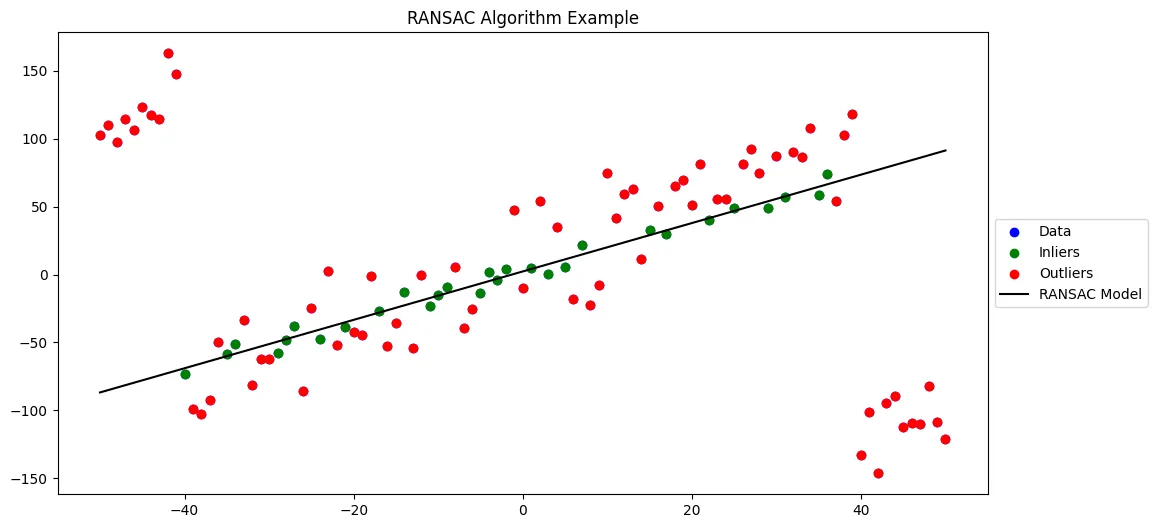

### **Random sample consensus (RANSAC)** is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates. Therefore, it also can be interpreted as an outlier detection method.

### **RANSAC** uses repeated **random sub-sampling**. A basic assumption is that the data consists of **"inliers"**, i.e., data whose distribution can be explained by some set of model parameters, though may be subject to noise, and **"outliers"** which are data that do not fit the model. RANSAC also assumes that, given a (usually small) set of inliers, there exists a procedure which can estimate the parameters of a model that optimally explains or fits this data.

### **RANSAC achieves its goal by repeating the following steps:**

**1.** Select a random subset of the original data. Call this subset the hypothetical inliers.

**2.** A model is fitted to the set of hypothetical inliers.
All data are then tested against the fitted model.

**3.** All the data points (of the original data) that fit the estimated model well, according to some model-specific loss function, are called the consensus set (i.e., the set of inliers for the model).

**4.** The estimated model is reasonably good if sufficiently many data points have been classified as a part of the consensus set.

**5.** The model may be improved by re-estimating it by using all the members of the consensus set. The fitting quality as a measure of how well the model fits to the consensus set will be used to sharpen the model fitting as iterations goes on (e.g., by setting this measure as the fitting quality criteria at the next iteration).

## **`Implementing RANSAC with Gaussian Mixture Model from scratch for Clustering and Outlier Detection`**

In [ ]:
class RANSAC_GMM:
  def __init__(self, n_estimators = 100, n_components = 1, contamination = 0.05, max_samples = 0.5, random_state = 1):
    self.n_estimators = n_estimators
    self.n_components = n_components
    self.contamination = contamination
    self.max_samples = max_samples
    self.random_state = random_state

  def fit_predict(self, X):
    import numpy as np
    from scipy.stats import multivariate_normal
    from sklearn.mixture import GaussianMixture
    from sklearn.utils import check_random_state
    from sklearn.utils.random import sample_without_replacement

    n, d = X.shape
    max_concensus_set_len = 0
    max_log_likelihood = -np.inf
    model = None
    random_state = check_random_state(self.random_state)

    gmm = GaussianMixture(self.n_components, max_iter = 300, random_state = random_state, warm_start = True)

    for i in range(self.n_estimators):
      rand_sample_indexes = sample_without_replacement(n_population = n, n_samples = int(n * self.max_samples),
                                                       random_state = random_state)
      rand_sample = X[rand_sample_indexes]   # Random sampling from data --> Possible inliers
      gmm.fit(rand_sample)                   # Fitting Guassian Mixture Model on the sample
      gmm_means, gmm_covariances = gmm.means_, gmm.covariances_


      # Calculating one-tailed probability of each data point (from whole data) for each of the clusters (or gaussians)
      # in Guassian Mixture Model
      sample_probas = np.array([[min(multivariate_normal(mean = gmm_means[i], cov = gmm_covariances[i]).cdf(pt),
                            1 - multivariate_normal(mean = gmm_means[i], cov = gmm_covariances[i]).cdf(pt))\
                                 for i in range(self.n_components)] for pt in X])

      # Inliers - Datapoints having one-tailed probability > 0.05 for atleast one of the clusters (or gaussians)
      # in Guassian Mixture Model
      concensus_set = X[np.any(sample_probas > 0.05, axis = 1)]
      concensus_set_len = concensus_set.shape[0]

      # If the size of inliers or concensus is greater than the previous,
      # then this is the better fit model (after fitting on inliers).
      if concensus_set_len > max_concensus_set_len:
        gmm.fit(concensus_set)
        log_likelihood = np.sum(gmm.score_samples(concensus_set))
        model = gmm
        max_log_likelihood = log_likelihood
        max_concensus_set_len = concensus_set_len

      # If the size of inliers or concensus is equal to the previous, then this is the better fit model
      # only and only if the current log likelihood (after fitting on inliers) is greater than the previous.
      elif concensus_set_len == max_concensus_set_len:
        gmm.fit(concensus_set)
        likelihood = np.sum(gmm.score_samples(concensus_set))
        if log_likelihood > max_log_likelihood:
          model = gmm
          max_log_likelihood = log_likelihood
          max_concensus_set_len = concensus_set_len
      else:
        continue

    labels = model.predict(X)    # Label data as per the best fit model
    pt_log_likelihoods = model.score_samples(X)
    threshold_log_likelihood = np.percentile(pt_log_likelihoods, self.contamination * 100)
    labels[pt_log_likelihoods < threshold_log_likelihood] = -1   # Pts with log likelihood < 5th percentile value
                                                                 # of log likelihood are outliers.
    self.labels_ = labels
    self.best_estimator_ = model
    return labels